# 粒子滤波器Particle-Filters

本节介绍粒子滤波器，这个滤波器的想法类似于UKF方法，只是改换了UKF方法中sigma点而采用Monte-Carlo随机种子。这种情况下描述同一状态的描述点相比于UKF更多，能有更大可能对状态估计更加准确。粒子群是建立在随机分布Monte-Carlofen'x分析的基础上，通常在使用过程分为：已知初始状态而采用高斯分布处理；未知初始状态而采用均匀分布处理。
    
This section introduces the particle filter. The nature of this filter is similar to the UKF method, except that the sigma point in the UKF method is changed and the Monte-Carlo random seed are used. In this case, these points describing the same state are more than the UKF, and there is a greater possibility that the state estimation is more accurate. The particle swarm is based on the Monte-Carlo simulation of random distribution. It is usually divided into: known initial state and Gaussian distribution; unknown initial state and uniform distribution.

<img src='particle_filter_anim.gif'>

# Algorithm

接下来先给出整个算法过程，并分别叙述。

** Initialization：**

1. Determine the position of NL measuring points）：**landmarkd = [ [ ], [ ],……]**
2. Generating a particle swarm of N random points ：  
    
    Is there an initial state variable initial_x? 
    - Yes：Gaussian distribution：**create_gaussian_particles(mean, P_std, N)**
    - No： Uniform distribution：**create_uniform_particles(x_range, y_range, …, N)**  

3. Initialization of weight coefficients：**weights = np.zeros(N)**

** Loop：**

4. Pre-estimation of the particle states：**particles = predict(particles, u, Q_std)**
5. Generate the measurements of the new state：**zs**
6. Generate a weight coefficients for each particle, which is the probability of the particle state under the measured conditions：**weights = update(particles, weights, z, R_std, landmarks)**
7. Resample：  
    if **neff(weights) < N/2**, then  
      Get a resampled index：***indexes***  
      Resampling and resetting weight coefficients：**resample_from_indexes(particles, weights, indexes)**
8. Estimate the new state variable：**[$\mu, \sigma^2$] = estimate(particles,weights)**

接下来，我们给一个例题，并在例题前，逐步讲解每一个步骤的内容：

## 1、生成粒子群 Generating particle swarm

前面已经知道了，通常生成粒子群有两种方案。  
在未知初值情况下，我们采用均匀分布设置N个随机点，这样有利于等可能的考虑到全域内任何一个可能出现新状态的位置。但是相比于在已知初始点处采用高斯分布来设置随机点的方法，这样显然会更加粗糙更加不精确。因此，通常情况下，我们更愿意采用高斯分布的方法，而对于未知的初值，我们可以假设为接近初始测量值的值。  

Aforementionedly, there are usually two scenarios for generating particle swarms.  
In the case of unknown initial values, we use a uniform distribution to set N random points, which is beneficial to consider the possible location of any new state in the whole domain. However, this is obviously more rough and less accurate than the method of setting a random point using a Gaussian distribution at a known initial point. Therefore, in general, we prefer to use the Gaussian distribution method, and for the unknown initial value, we can assume the value close to the initial measurement.

In [4]:
from numpy.random import uniform
def create_uniform_particles(x_range, y_range, hdg_range, N):
    particles = np.empty((N, 3))
    particles[:, 0] = uniform(x_range[0], x_range[1], size=N)
    particles[:, 1] = uniform(y_range[0], y_range[1], size=N)
    particles[:, 2] = uniform(hdg_range[0], hdg_range[1], size=N)
    particles[:, 2] %= 2 * np.pi
    return particles

def create_gaussian_particles(mean, P_std, N):
    particles = np.empty((N, 3))
    particles[:, 0] = mean[0] + (randn(N) * P_std[0])
    particles[:, 1] = mean[1] + (randn(N) * P_std[1])
    particles[:, 2] = mean[2] + (randn(N) * P_std[2])
    particles[:, 2] %= 2 * np.pi
    return particles

## 2、状态先验假设预估计 Pre-estimation of particle states

预估计阶段，事实上就是对这些粒子点在dt时间后的位置先验假设估计，从而使粒子群从前一状态推移到新状态附近。  

The pre-estimation is to estimate the state of these particle points after the dt time according to the system model, so that these particles  moves from the previous state to the vicinity of the new state.

$$particles <== predict(particles, u, Q_std, dt) $$

In [5]:
def predict(particles, u, Q_std, dt=1.):
    """ move according to control input u (heading change, velocity)
    with noise Q (std heading change, std velocity)`"""

    N = len(particles)
    # update heading
    particles[:, 2] += u[0] + (randn(N) * Q_std[0])
    particles[:, 2] %= 2 * np.pi

    # move in the (noisy) commanded direction
    dist = (u[1] * dt) + (randn(N) * Q_std[1])                #u[1]是速度控制标量，randn(N)是N维随机矢量
    particles[:, 0] += np.cos(particles[:, 2]) * dist
    particles[:, 1] += np.sin(particles[:, 2]) * dist

## 3、状态后验假设估计 Posterior estimation of particles states

在后验估计过程中，我们根据标定点测量到的那些数据得到实际状态的联合分布，并根据这个分布获得此时每个粒子的概率（即权值weights）。 

In the a posteriori estimation process, we obtain the joint distribution of the actual states based on the data measured at the calibration point, and obtain the probability of each particle at this time according to this distribution.

$$weights <== update(particles, weights, z, R_std, landmarks)$$

In [6]:
def update(particles, weights, z, R_std, landmarks):
    weights.fill(1.)
    for i, landmark in enumerate(landmarks):
        distance = np.linalg.norm(particles[:, 0:2] - landmark, axis=1) # axis=1: 横向求两点间距离（方和根）），纵向维数一致； axis=0: 纵向求方和根
        weights *= scipy.stats.norm(distance, R_std).pdf(z[i])

    weights += 1.e-300      # avoid round-off to zero
    weights /= sum(weights) # normalize

## 4、重采用条件 Resample condition: neff(weights) < N/2

neff函数求解得到有效值，当有效值小于N/2时（有时候也用N），则我们认为，这个时候很多的点意义不大了，我们可以将这些点忽略掉。

The neff function solves the rms value. When the RMS value is less than N/2 (and sometimes N), we think that many points at this time are of little significance, we can ignore these points.

In [7]:
def neff(weights):
    return 1. / np.sum(np.square(weights))   # 这里的square函数是标量运算，是对数组中每个元素进行运算操作

## 5、Resample

进而，我们就将那些权值较大的点，也就是距离目标较近的粒子点保留下来。  

Furthermore, we keep those points with larger weights,that the points closer to the target.

在这时，在获取这些粒子点的索引时候，通常有四种方法：

There are usually four ways to get the index of these particle points:
```python
import filterpy.monte-carlo as mc
mc.multinomial_resample
mc.residual_resample
mc.stratified_resample
mc.systematic_resample
```
这四种方法中，推荐使用后两种，其效率较高，具体对比可以参看书中最后部分。

Of the four methods, the latter two are recommended, which are more efficient.

In [8]:
def resample_from_index(particles, weights, indexes):
    particles[:] = particles[indexes]
    #weights[:] = weights[indexes]
    weights.fill (1.0 / len(weights))

## 6、Estimation

最后的估计部分，实际上就是对每个粒子作用于他自己的权值，从而获得这一状态的估计值，粒子分布的方差也就是这一状态的不确定性。  

The final part of the estimation is actually to weight each particle to obtain an estimate of this state. The variance of the particle distribution is the uncertainty of this state.

In [9]:
def estimate(particles, weights):
    """returns mean and variance of the weighted particles"""

    pos = particles[:, 0:2]
    mean = np.average(pos, weights=weights, axis=0)  #此时保持横向维度不变，纵向求均值，即对各粒子点加权求均值
    var  = np.average((pos - mean)**2, weights=weights, axis=0)
    return mean, var

final position error, variance:
	 [-0.10621456  0.1061402 ] [ 0.00859646  0.00757081]


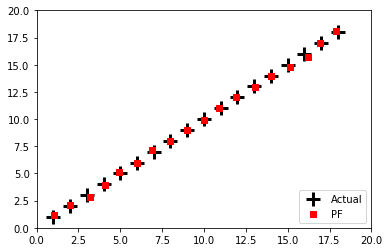

In [10]:
from filterpy.monte_carlo import systematic_resample
import numpy as np
from numpy.linalg import norm
from numpy.random import randn
import matplotlib.pyplot as plt
import scipy.stats

def run_pf1(N, iters=18, sensor_std_err=.1, 
            do_plot=True, plot_particles=False,
            xlim=(0, 20), ylim=(0, 20),
            initial_x=None):
    landmarks = np.array([[-1, 2], [5, 10], [12,14], [18,21]])
    NL = len(landmarks)
    
    plt.figure()
   
    # create particles and weights
    if initial_x is not None:
        particles = create_gaussian_particles(
            mean=initial_x, P_std=(5, 5, np.pi/4), N=N)
    else:
        particles = create_uniform_particles((0,20), (0,20), (0, 6.28), N)
    weights = np.zeros(N)

    if plot_particles:
        alpha = .20
        if N > 5000:
            alpha *= np.sqrt(5000)/np.sqrt(N)           
        plt.scatter(particles[:, 0], particles[:, 1], 
                    alpha=alpha, color='g')
    
    xs = []
    robot_pos = np.array([0., 0.])
    for x in range(iters):
        robot_pos += (1, 1)

        # distance from robot to each landmark
        zs = (norm(landmarks - robot_pos, axis=1) + 
              (randn(NL) * sensor_std_err))

        # move diagonally forward to (x+1, x+1)
        predict(particles, u=(0.00, 1.414), Q_std=(.2, .05))
        
        # incorporate measurements
        update(particles, weights, z=zs, R_std=sensor_std_err, 
               landmarks=landmarks)
        
        # resample if too few effective particles
        if neff(weights) < N/2:
            indexes = systematic_resample(weights)          # 采用systematic_resample方法获取重抽样索引
            resample_from_index(particles, weights, indexes)

        mu, var = estimate(particles, weights)
        xs.append(mu)

        if plot_particles:
            plt.scatter(particles[:, 0], particles[:, 1], 
                        color='k', marker=',', s=1)
        p1 = plt.scatter(robot_pos[0], robot_pos[1], marker='+',
                         color='k', s=180, lw=3)
        p2 = plt.scatter(mu[0], mu[1], marker='s', color='r')
    
    xs = np.array(xs)
    #plt.plot(xs[:, 0], xs[:, 1])
    plt.legend([p1, p2], ['Actual', 'PF'], loc=4, numpoints=1)
    plt.xlim(*xlim)
    plt.ylim(*ylim)
    print('final position error, variance:\n\t', mu - np.array([iters, iters]), var)
    plt.show()

from numpy.random import seed
seed(2) 
run_pf1(N=5000, plot_particles=False)
